# Training

In [ ]:
from config.config import *
import tf_keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'tf_keras'

In [2]:
from processing.preprocessing import Dataset
from training.model import create_model, plot_model

In [ ]:
train_dataset = Dataset.create_training_pipeline(DF)
val_dataset = Dataset.create_validation_pipeline(DF)

In [3]:
name = 'model_test'

test_dataset = Dataset.create_test_pipeline(DF)
keras.mixed_precision.set_global_policy('mixed_float16')

I0000 00:00:1735406155.538110     899 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9


In [ ]:
lmodel = keras.models.load_model(SERIALIZATION_DIR.joinpath(f'{name}.keras'))

In [6]:
lpredictions = lmodel.predict(test_dataset.pipeline)

2024-12-14 17:00:41.446026: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1734175841.636859    2183 cuda_dnn.cc:529] Loaded cuDNN version 90300


942/942 [==============================] - 43s 42ms/step


2024-12-14 17:01:22.435120: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-14 17:01:22.435288: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-12-14 17:01:22.435330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16303143433776121667
2024-12-14 17:01:22.435349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10221427589126133451
2024-12-14 17:01:22.435366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1290116226194515673


In [129]:
preds = np.argmax(lpredictions['outputs'], axis=-1)

In [7]:
lmodel.evaluate(test_dataset.pipeline)

942/942 [==============================] - 40s 40ms/step - loss: 0.9084 - accuracy: 0.8410


2024-12-14 17:02:02.722482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5115528793007358470
2024-12-14 17:02:02.722570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8048777480390521892
2024-12-14 17:02:02.722580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10221427589126133451
2024-12-14 17:02:02.722586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16303143433776121667
2024-12-14 17:02:02.722697: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


[0.9083868861198425, 0.8410485982894897]

In [16]:
groundd_truth = np.array([np.argmax(l) for f,l in test_dataset.pipeline.unbatch().as_numpy_iterator()])

In [19]:
import testing.evaluation


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fd1cc4f5f10>,
             BACKGROUND  CONCLUSIONS      METHODS    OBJECTIVE      RESULTS  \
 precision     0.691925     0.876745     0.905524     0.723333     0.844378   
 recall        0.806959     0.879239     0.862888     0.465066     0.903840   
 f1-score      0.745028     0.877990     0.883692     0.566136     0.873098   
 support    3621.000000  4571.000000  9897.000000  2333.000000  9713.000000   
 
            accuracy     macro avg  weighted avg  
 precision  0.841049      0.808381      0.841680  
 recall     0.841049      0.783598      0.841049  
 f1-score   0.841049      0.789189      0.838166  
 support    0.841049  30135.000000  30135.000000  ,
 {'accuracy': 84.10486145677784,
  'precision': 0.8416797639427656,
  'recall': 0.8410486145677784,
  'f1': 0.8381661220758132})

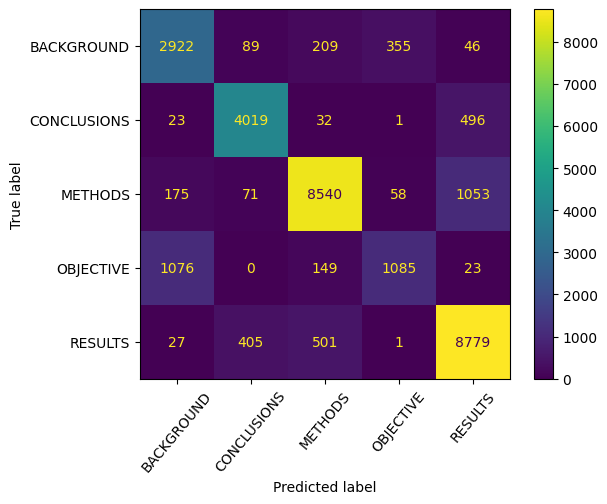

In [22]:
testing.evaluation.get_cm_and_final_results(preds, groundd_truth)

In [119]:
transition_matrix = np.zeros(shape=(NUM_CLASSES,NUM_CLASSES))
for f,label in train_dataset.pipeline.unbatch().as_numpy_iterator():
    if f['line_of']:
        transition_matrix[last,:] = transition_matrix[last,:] + label
    last = np.argmax(label)


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1.1363e+04 4.0000e+00 5.4920e+03 1.8330e+03 3.4300e+02]
 [2.6300e+03 1.2345e+04 2.0200e+02 1.1000e+01 7.0000e+00]
 [1.0500e+02 8.5700e+02 4.4551e+04 5.9000e+01 1.3553e+04]
 [2.3300e+02 7.0000e+00 9.0050e+03 4.4150e+03 1.7800e+02]
 [9.0000e+00 1.3942e+04 2.4000e+01 0.0000e+00 4.3872e+04]]


In [154]:
transition_matrix.sum()

165040.0

In [118]:
transition_probabilities = transition_matrix/np.repeat(np.sum(transition_matrix, axis=-1), NUM_CLASSES).reshape(NUM_CLASSES,NUM_CLASSES)

In [171]:
def add_matrix_v1(dataset : Dataset, predictions, weight):
    test = predictions['outputs'].copy()
    for i, (features, labels) in enumerate(dataset.pipeline.unbatch().as_numpy_iterator()):
        probabilities = test[i,...]
        line = features['line_of']
        if line:
            # print('last:', last_probs, '====> now', probabilities)
            test[i,...] = probabilities * (1-weight) + np.dot(transition_probabilities, last_probs) * weight
        last_probs =  test[i,...]
    return test

In [160]:
def add_matrix_v2(dataset : Dataset, predictions, weight):
    test = predictions['outputs'].copy()
    for i, (features, labels) in enumerate(dataset.pipeline.unbatch().as_numpy_iterator()):
        probabilities = test[i,...]
        line = features['line_of']
        if line:
            # print('last:', last_probs, '====> now', probabilities)
            x = probabilities*np.dot(transition_probabilities, last_probs)
            test[i,...] = x/x.sum()
        last_probs =  test[i,...]
    return test

In [161]:
new = add_matrix_v2(test_dataset,predictions=lpredictions, weight=0.3)

In [162]:
preds2 = np.argmax(new, axis=-1)

In [167]:
preds, preds2, groundd_truth


(array([0, 4, 2, ..., 4, 4, 1]),
 array([0, 0, 2, ..., 4, 4, 4]),
 array([0, 4, 4, ..., 4, 4, 1]))

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fd16862dd30>,
             BACKGROUND  CONCLUSIONS      METHODS    OBJECTIVE      RESULTS  \
 precision     0.691925     0.876745     0.905524     0.723333     0.844378   
 recall        0.806959     0.879239     0.862888     0.465066     0.903840   
 f1-score      0.745028     0.877990     0.883692     0.566136     0.873098   
 support    3621.000000  4571.000000  9897.000000  2333.000000  9713.000000   
 
            accuracy     macro avg  weighted avg  
 precision  0.841049      0.808381      0.841680  
 recall     0.841049      0.783598      0.841049  
 f1-score   0.841049      0.789189      0.838166  
 support    0.841049  30135.000000  30135.000000  ,
 {'accuracy': 84.10486145677784,
  'precision': 0.8416797639427656,
  'recall': 0.8410486145677784,
  'f1': 0.8381661220758132})

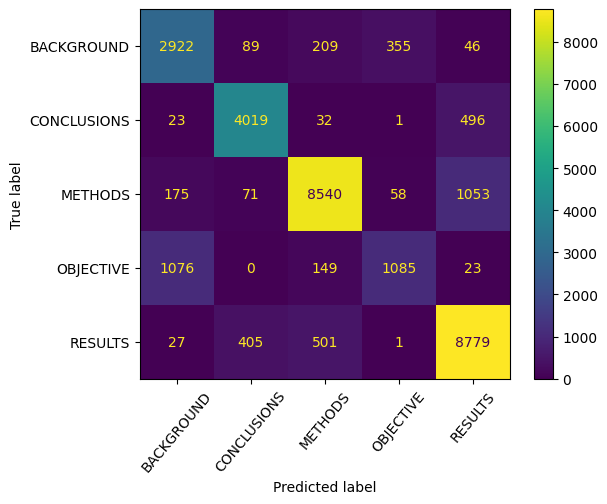

In [158]:
testing.evaluation.get_cm_and_final_results(preds, groundd_truth)

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fd1459309b0>,
             BACKGROUND  CONCLUSIONS      METHODS    OBJECTIVE      RESULTS  \
 precision     0.679571     0.880374     0.907363     0.745324     0.851920   
 recall        0.804750     0.864581     0.877842     0.444063     0.911562   
 f1-score      0.736882     0.872406     0.892358     0.556540     0.880732   
 support    3621.000000  4571.000000  9897.000000  2333.000000  9713.000000   
 
            accuracy     macro avg  weighted avg  
 precision  0.844334      0.812910      0.845483  
 recall     0.844334      0.780560      0.844334  
 f1-score   0.844334      0.787784      0.840904  
 support    0.844334  30135.000000  30135.000000  ,
 {'accuracy': 84.43338310934129,
  'precision': 0.8454827525727264,
  'recall': 0.844333831093413,
  'f1': 0.8409041999101674})

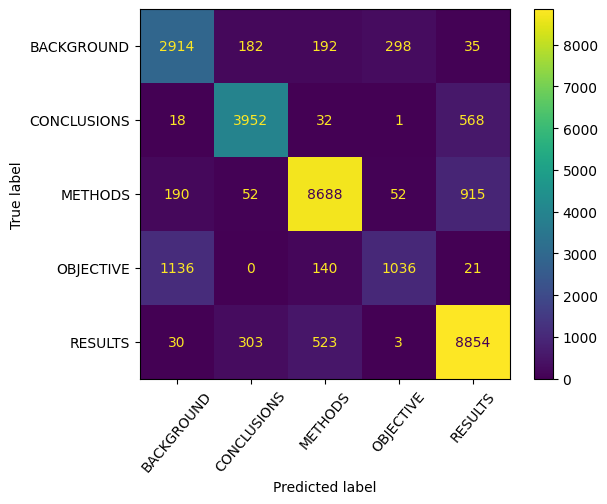

In [159]:
testing.evaluation.get_cm_and_final_results(preds2, groundd_truth)

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fd1477901a0>,
             BACKGROUND  CONCLUSIONS      METHODS    OBJECTIVE      RESULTS  \
 precision     0.492398     0.760699     0.704980     0.553866     0.674294   
 recall        0.831814     0.361628     0.785187     0.359194     0.646247   
 f1-score      0.618608     0.490214     0.742925     0.435777     0.659973   
 support    3621.000000  4571.000000  9897.000000  2333.000000  9713.000000   
 
            accuracy     macro avg  weighted avg  
 precision   0.64878      0.637248      0.666299  
 recall      0.64878      0.596814      0.648780  
 f1-score    0.64878      0.589499      0.639139  
 support     0.64878  30135.000000  30135.000000  ,
 {'accuracy': 64.8780487804878,
  'precision': 0.6662986072625612,
  'recall': 0.6487804878048781,
  'f1': 0.6391392082496492})

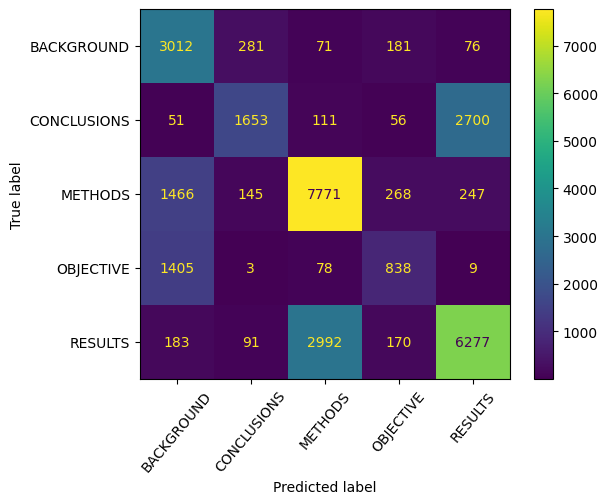

In [166]:
testing.evaluation.get_cm_and_final_results(preds2, groundd_truth)

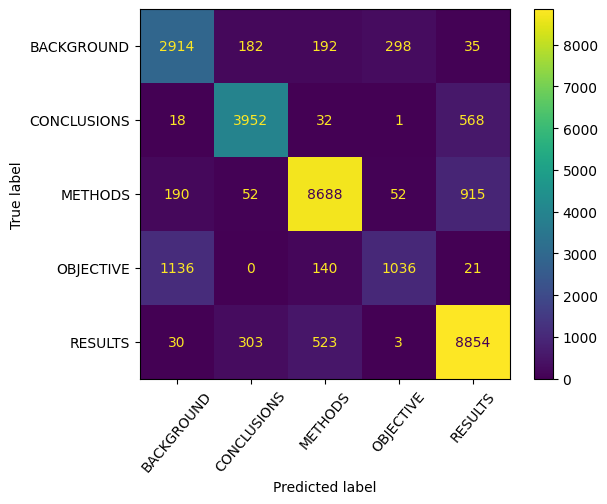

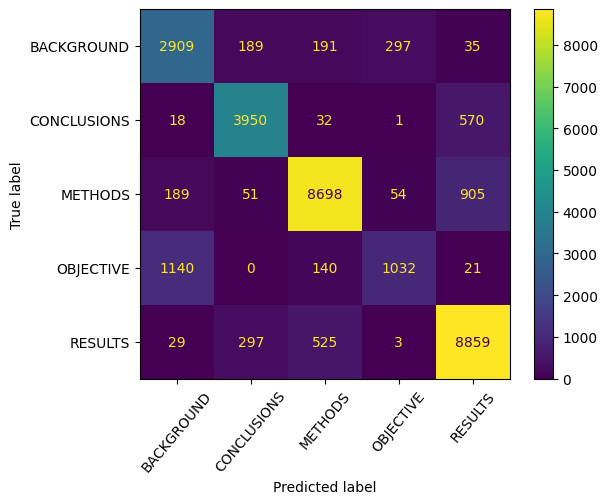

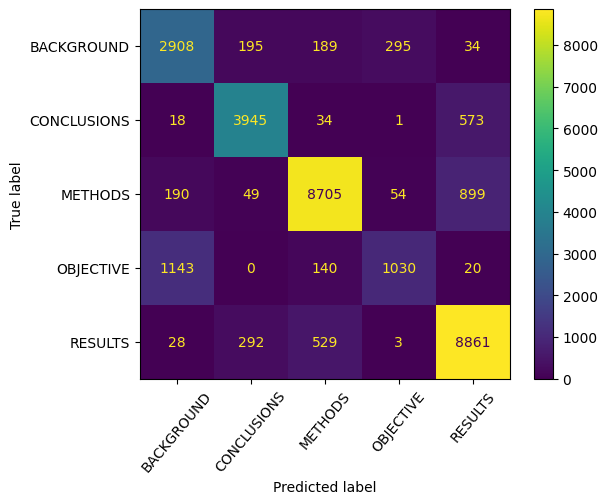

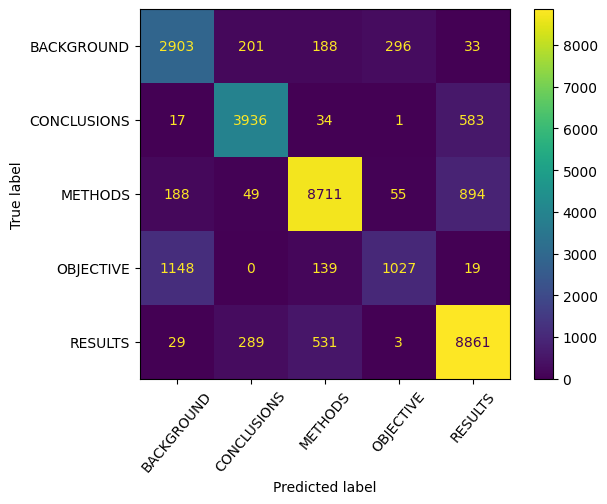

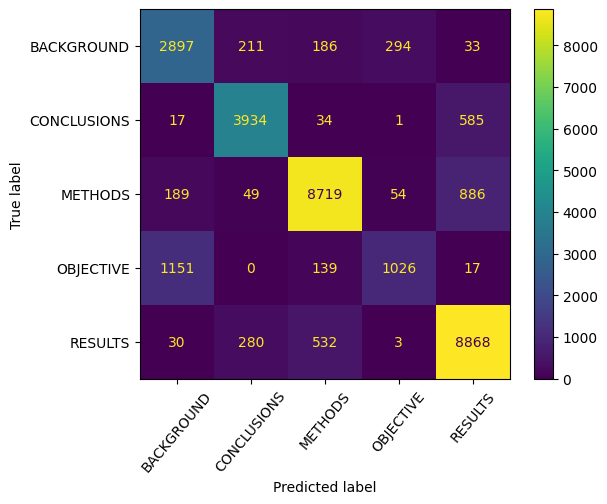

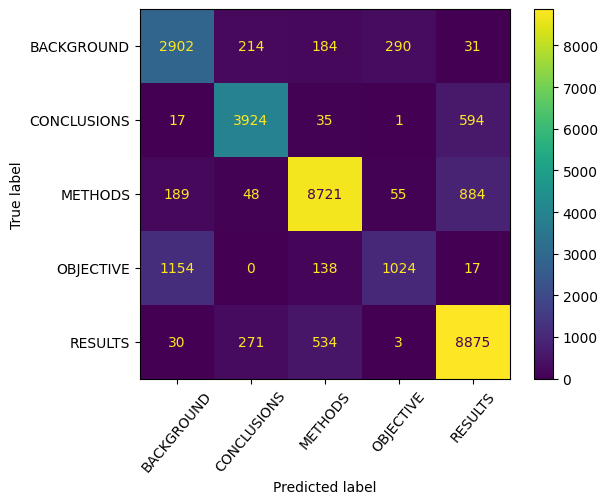

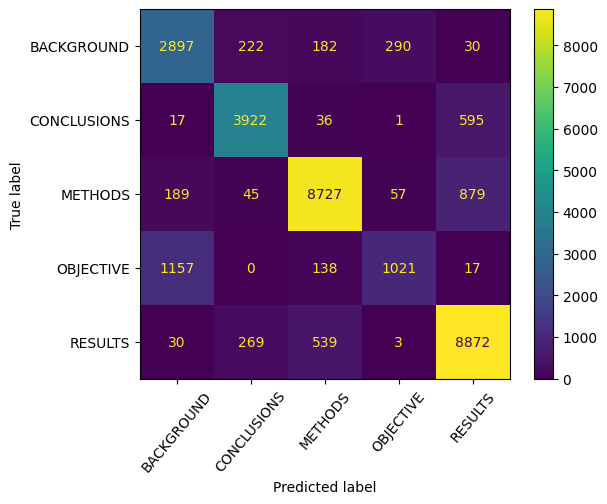

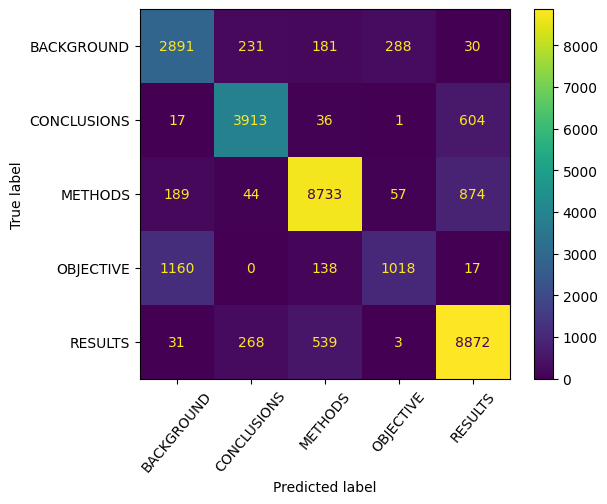

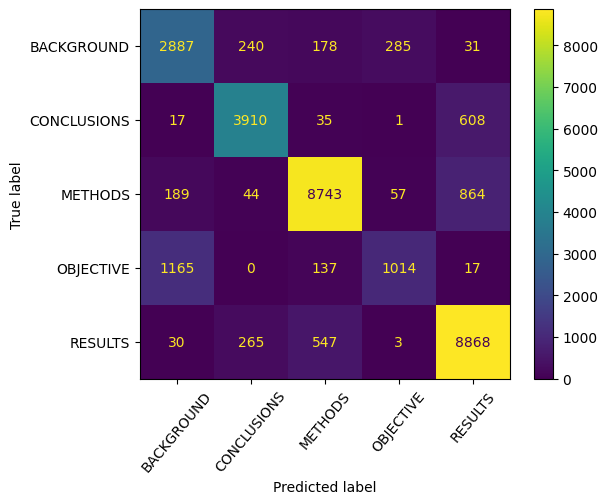

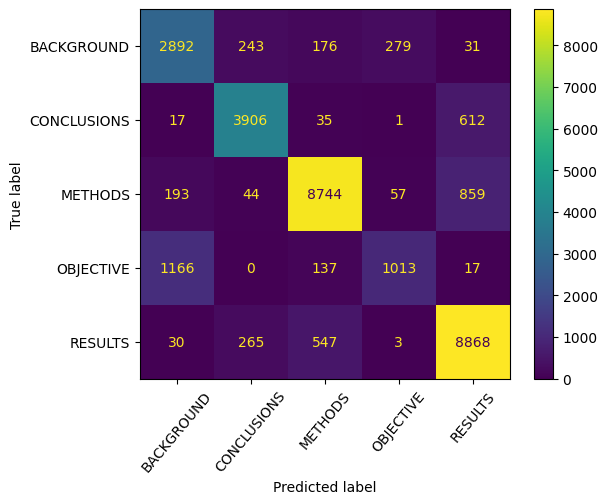

In [180]:
mets = []
for i in range(10):
    preds2 = np.argmax(add_matrix_v1(test_dataset,predictions=lpredictions, weight=0.3 + 0.01 * i), axis=-1)
    _,r,_ = testing.evaluation.get_cm_and_final_results(preds2, groundd_truth)
    mets.append(r)

In [175]:
from IPython.display import display

In [179]:
for r in mets:
    display(r)

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.691925,0.876745,0.905524,0.723333,0.844378,0.841049,0.808381,0.841680
recall,0.806959,0.879239,0.862888,0.465066,0.903840,0.841049,0.783598,0.841049
f1-score,0.745028,0.877990,0.883692,0.566136,0.873098,0.841049,0.789189,0.838166
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.841049,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.688779,0.883054,0.906118,0.727088,0.846716,0.842741,0.810351,0.843498
recall,0.808616,0.875520,0.867940,0.459066,0.906517,0.842741,0.783532,0.842741
f1-score,0.743902,0.879271,0.886618,0.562796,0.875597,0.842741,0.789637,0.839733
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.842741,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.685459,0.884196,0.907077,0.731809,0.848732,0.843803,0.811455,0.844602
recall,0.805855,0.870269,0.872891,0.452636,0.909812,0.843803,0.782292,0.843803
f1-score,0.740797,0.877178,0.889656,0.559322,0.878211,0.843803,0.789033,0.840614
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.843803,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.679571,0.880374,0.907363,0.745324,0.851920,0.844334,0.812910,0.845483
recall,0.804750,0.864581,0.877842,0.444063,0.911562,0.844334,0.780560,0.844334
f1-score,0.736882,0.872406,0.892358,0.556540,0.880732,0.844334,0.787784,0.840904
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.844334,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.672009,0.875701,0.907413,0.747961,0.854707,0.843803,0.811558,0.844984
recall,0.798951,0.853861,0.884308,0.432490,0.913312,0.843803,0.776585,0.843803
f1-score,0.730003,0.864643,0.895712,0.548072,0.883038,0.843803,0.784293,0.840089
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.843803,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.659453,0.873458,0.905286,0.749418,0.855805,0.841181,0.808684,0.842903
recall,0.799503,0.836578,0.889461,0.414059,0.912283,0.841181,0.770377,0.841181
f1-score,0.722756,0.854621,0.897304,0.533407,0.883141,0.841181,0.778246,0.837119
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.841181,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.641692,0.869938,0.903193,0.702848,0.852399,0.833084,0.794014,0.834845
recall,0.804198,0.798950,0.888956,0.391342,0.909091,0.833084,0.758507,0.833084
f1-score,0.713813,0.832934,0.896018,0.502753,0.879833,0.833084,0.765070,0.828893
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.833084,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.597347,0.864594,0.902669,0.511111,0.830475,0.802588,0.741239,0.806623
recall,0.808340,0.718005,0.871476,0.354908,0.877587,0.802588,0.726063,0.802588
f1-score,0.687009,0.784511,0.886798,0.418922,0.853381,0.802588,0.726124,0.800283
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.802588,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.509807,0.841366,0.897183,0.280870,0.776423,0.720425,0.661130,0.755533
recall,0.818282,0.576679,0.752955,0.326618,0.813034,0.720425,0.657514,0.720425
f1-score,0.628220,0.684320,0.818766,0.302021,0.794307,0.720425,0.645527,0.727588
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.720425,30135.000000,30135.000000


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.426213,0.616885,0.888648,0.245929,0.742710,0.638195,0.584077,0.695064
recall,0.798398,0.484358,0.580580,0.317188,0.786678,0.638195,0.593440,0.638195
f1-score,0.555748,0.542647,0.702316,0.277050,0.764062,0.638195,0.568365,0.647464
support,3621.000000,4571.000000,9897.000000,2333.000000,9713.000000,0.638195,30135.000000,30135.000000
